In [1]:
import os
os.chdir('../')
current_directory = os.getcwd()
print("Current Directory:", current_directory)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

import warnings; 
warnings.simplefilter('ignore')

Current Directory: c:\Users\Darren Chong\Documents\School\Thesis B\Spectrogram-Based-Omics-Imagification


In [2]:
expr_file1 = r"./data/Isolet/isolet1234.data"
expr_file2 = r"./data/Isolet/isolet5.data"
expr1 = pd.read_csv(expr_file1, sep=",", header=None)
expr2 = pd.read_csv(expr_file2, sep=",", header=None)
expr = pd.concat([expr1, expr2], ignore_index=True)
y = expr.iloc[:, -1].values
X = expr.iloc[:, :-1].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)
print(np.unique(y, return_counts=True))

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.]), array([300, 300, 300, 300, 300, 298, 300, 300, 300, 300, 300, 300, 299,
       300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300],
      dtype=int64))


In [3]:
def scaler_fit(X: np.ndarray) -> tuple:
    """Compute parameters needed for log normalization and scaling."""
    min0 = X.min(axis=0)
    max_val = np.log(X + np.abs(min0) + 1).max()
    return min0, max_val

def scaler_transform(X: np.ndarray, min0: np.ndarray, max_val: float) -> np.ndarray:
    """Apply log normalization and scaling to the input data."""
    X_norm = np.log(X + np.abs(min0) + 1).clip(0, None)
    return (X_norm / max_val).clip(0, 1)

def scaler_fit_transform(X: np.ndarray) -> np.ndarray:
    """Combine fitting and transforming steps."""
    min0, max_val = scaler_fit(X)
    return (scaler_transform(X, min0, max_val), min0, max_val)

(X_train_norm, min0, max_val) = scaler_fit_transform(X_train)
X_test_norm = scaler_transform(X_test, min0, max_val)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = np.unique(y_train_enc).size

Training Accuracy: 0.19737053070386404
Test Accuracy: 0.18846153846153846
Precision (Macro): 0.16716851658189677
Precision (Micro): 0.18846153846153846
Precision (Weighted): 0.16716851658189677
Recall (Macro): 0.18846153846153849
Recall (Micro): 0.18846153846153846
Recall (Weighted): 0.18846153846153846
F1-score (Macro): 0.11005994402312888
F1-score (Micro): 0.18846153846153846
F1-score (Weighted): 0.11005994402312887
ROC-AUC (OvO, Macro): 0.8095237179487178
ROC-AUC (OvO, Weighted): 0.809523717948718


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.00      0.00      0.00        60
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00        60
           4       0.00      0.00      0.00        60
           5       0.39      0.88      0.54        60
           6       0.00      0.00      0.00        60
           7       1.00      0.02      0.03        60
     

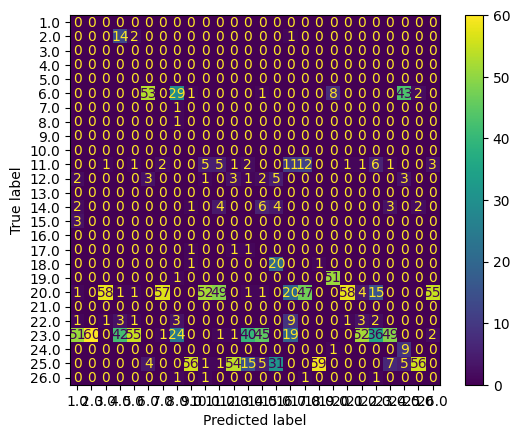

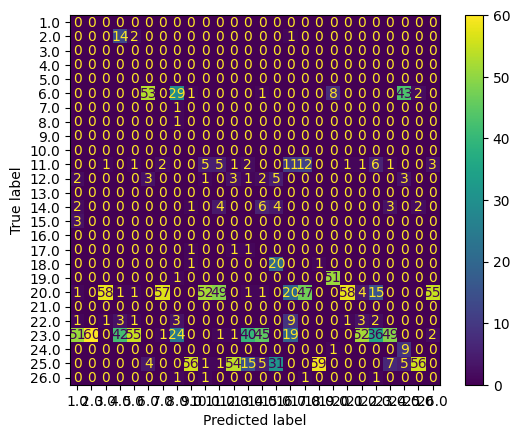

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

clf = AdaBoostClassifier(n_estimators=50, algorithm='SAMME', random_state=42)
clf.fit(X_train_norm, y_train_enc)
y_pred = clf.predict(X_test_norm)
# Calculate evaluation metrics
precision_macro = precision_score(y_test_enc, y_pred, average='macro')
precision_micro = precision_score(y_test_enc, y_pred, average='micro')
precision_weighted = precision_score(y_test_enc, y_pred, average='weighted')
recall_macro = recall_score(y_test_enc, y_pred, average='macro')
recall_micro = recall_score(y_test_enc, y_pred, average='micro')
recall_weighted = recall_score(y_test_enc, y_pred, average='weighted')
f1_macro = f1_score(y_test_enc, y_pred, average='macro')
f1_micro = f1_score(y_test_enc, y_pred, average='micro')
f1_weighted = f1_score(y_test_enc, y_pred, average='weighted')
roc_auc_macro = roc_auc_score(y_test_enc, clf.predict_proba(X_test), average='macro', multi_class='ovo')
roc_auc_weighted = roc_auc_score(y_test_enc, clf.predict_proba(X_test), average='weighted', multi_class='ovo')
# Classification report (includes precision, recall, F1-score, support)
report = classification_report(y_test_enc, y_pred)

train_accuracy = accuracy_score(y_train_enc, clf.predict(X_train_norm))

# Calculate test accuracy
test_accuracy = accuracy_score(y_test_enc, y_pred)


print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Precision (Macro):", precision_macro)
print("Precision (Micro):", precision_micro)
print("Precision (Weighted):", precision_weighted)
print("Recall (Macro):", recall_macro)
print("Recall (Micro):", recall_micro)
print("Recall (Weighted):", recall_weighted)
print("F1-score (Macro):", f1_macro)
print("F1-score (Micro):", f1_micro)
print("F1-score (Weighted):", f1_weighted)
print("ROC-AUC (OvO, Macro):", roc_auc_macro)
print("ROC-AUC (OvO, Weighted):", roc_auc_weighted)
print("\n")
print(report)
disp = ConfusionMatrixDisplay.from_predictions(y_pred, y_test_enc, display_labels=le.classes_)
disp.plot()